## Раздел IV-3. Модель на базе композиции случайных деревьев


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from datetime import datetime

In [2]:
# загрузим очищенный набор 
orders = pd.read_csv('orders_3-1.csv', low_memory=False, dtype={'CUST_ZIP_C': object})

### a) подготовка данных  для работы агоритма Random Forrest

In [3]:
# закодируем категориальные переменные в их цифровое представление

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#le.fit(orders.CUST_CITY)
orders.CUST_CITY = le.fit_transform(orders.CUST_CITY)
orders.CUST_NAM = le.fit_transform(orders.CUST_NAM)
orders.CUST_CAT = le.fit_transform(orders.CUST_CAT)

orders.CUST_CITY = orders.CUST_CITY.astype('category')
orders.CUST_NAM = orders.CUST_NAM.astype('category')
orders.CUST_CAT = orders.CUST_CAT.astype('category')

In [4]:
#### разделим выборку на обучающий и тестовый наборы (80%, 20%)
train = orders.iloc[:int(len(orders)*.8)]
test = orders [train.shape[0] :]

print 'обучающий набор: ', train.shape[0] 
print 'тестовый набор:  ', test.shape[0]

обучающий набор:  91834
тестовый набор:   22959


In [5]:
# выделим в выборках целевую переменную (SA_HDR_AMT) 
y_train = train.SA_HDR_AMT
X_train = train.drop('SA_HDR_AMT', axis=1)

y_test = test.SA_HDR_AMT
X_test = test.drop('SA_HDR_AMT', axis=1)

print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

(91834, 18) (91834,)
(22959, 18) (22959,)


### б) обучим случайный лес  на выборке X_train с кросс-валидацией на 3 фолда

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [56]:
# обучим регрессор на интервале случайных лесов от 10-100
# и накопим оценки качества по `r2` 

kf = KFold(n_splits=3, random_state=41, shuffle=True)   # генератор разбиений кросс-валидации

r2_scores = []
for trees in range(10,100,10):
    rf_model = RandomForestRegressor(n_estimators=trees, random_state=41, n_jobs=-1)
    r2_scores += [cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=kf).mean()]

In [59]:
print 'значения качества модели на интервале 10-100: ', r2_scores
best_trees = np.argmax(r2_scores)
print '\nмаксимальное r2 = {1} достигнуто при числе деревьев = {0}'.format((best_trees+1)*10, max(r2_scores))

значения качества модели на интервале 10-100:  [0.98228095163628915, 0.98440544544849973, 0.98466903310989429, 0.98425082998635371, 0.98516134130091537, 0.9844589128871144, 0.98466321567501025, 0.98457219415861497, 0.98433264821057698]

максимальное r2 = 0.985161341301 достигнуто при числе деревьев = 50


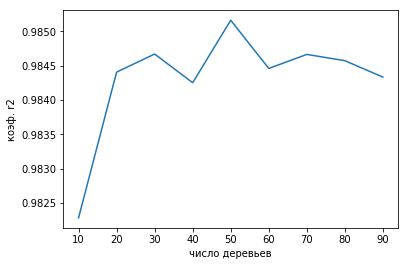

In [60]:
plt.figure()
plt.plot(range(10,100,10), r2_scores)
plt.ylabel(u'коэф. r2')
plt.xlabel(u'число деревьев')
plt.show()

In [61]:
# обучим модель на лучшем из композиции
rf_best_model = RandomForestRegressor(n_estimators=best_trees, random_state=41, n_jobs=-1)
rf_best_model.fit(X_train,y_train);

### в) построим прогноз и оценим качество модели по критерию r2

In [62]:
y_pred = rf_best_model.predict(X_test)   # построим прогнозные значения на тесте
y_true = np.array(y_test)       # истинные значения на тесте

In [63]:
from sklearn.metrics import r2_score
print 'коэф.детерминации r2 = {}'.format(r2_score(y_true, y_pred))

коэф.детерминации r2 = 0.892568377433


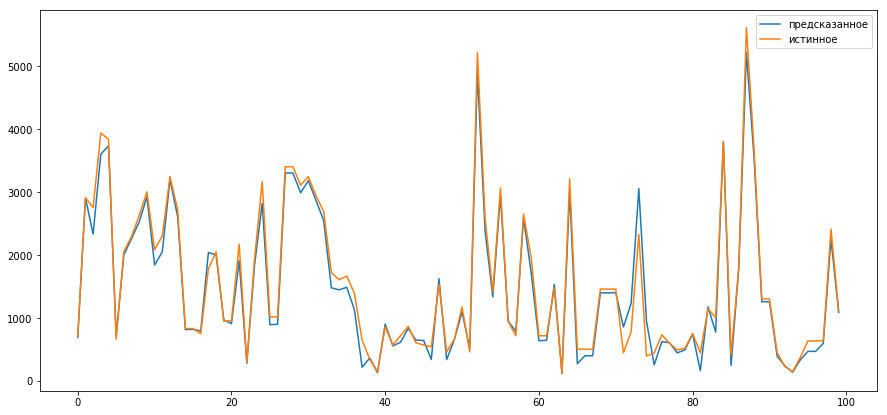

In [64]:
plt.figure(figsize=(15,7))
plt.plot(y_pred[1000:1100], label=u'предсказанное' )
plt.plot(y_true[1000:1100], label=u'истинное')
plt.legend();

## Вывод.
Прогноз на алгоритме случайного леса показала значение качества =  __0.892__, что почти совпадает с значением качества прогноза на решающих деревьях. 
